# Dog vs Cat Convolution + Pooling Demo

This notebook demonstrates step by step:
- Loading sample cat/dog images (`cat1, cat2, dog1, dog2` from your Desktop)
- Convolution with filters
- ReLU activation
- Pooling (with overlay windows shown)
- Feature extraction and a tiny logistic regression classifier


In [1]:
import os, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Path to your dataset folder (adjust if needed)
base = os.path.expanduser('~/Desktop/dogcat_demo')
images = {
    'cat1': os.path.join(base, 'cat1.jpg'),
    'cat2': os.path.join(base, 'cat2.jpg'),
    'dog1': os.path.join(base, 'dog1.jpg'),
    'dog2': os.path.join(base, 'dog2.jpg')
}

def load_image(path, size=128):
    img = Image.open(path).convert('RGB').resize((size,size))
    return np.array(img)/255.0

def to_grayscale(img):
    r,g,b = img[...,0], img[...,1], img[...,2]
    return 0.2989*r + 0.587*g + 0.114*b

def pad_image(img, pad):
    return np.pad(img, ((pad,pad),(pad,pad)), mode='constant')

def conv2d(image, kernel, stride=1, padding=0):
    kh, kw = kernel.shape
    kernel_flipped = np.flipud(np.fliplr(kernel))
    padded = pad_image(image, padding)
    H, W = padded.shape
    out_h = (H - kh)//stride + 1
    out_w = (W - kw)//stride + 1
    out = np.zeros((out_h,out_w))
    for i in range(out_h):
        for j in range(out_w):
            region = padded[i*stride:i*stride+kh, j*stride:j*stride+kw]
            out[i,j] = np.sum(region * kernel_flipped)
    return out

def relu(x):
    return np.maximum(0,x)

def pool2d(image, pool_size=2, stride=2, mode='max'):
    H,W = image.shape
    out_h = (H-pool_size)//stride + 1
    out_w = (W-pool_size)//stride + 1
    out = np.zeros((out_h,out_w))
    for i in range(out_h):
        for j in range(out_w):
            region = image[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
            out[i,j] = np.max(region) if mode=='max' else np.mean(region)
    return out

def draw_pooling_overlay(img, pool_size=2, stride=2):
    fig, ax = plt.subplots(1, figsize=(4,4))
    ax.imshow(img)
    H,W,_ = img.shape
    out_h = (H-pool_size)//stride + 1
    out_w = (W-pool_size)//stride + 1
    for i in range(out_h):
        for j in range(out_w):
            rect = patches.Rectangle((j*stride,i*stride), pool_size, pool_size,
                                     linewidth=1, edgecolor='r', facecolor='none', alpha=0.5)
            ax.add_patch(rect)
    plt.axis('off')
    plt.show()

kernels = {
    'sobel_x': np.array([[-1,0,1],[-2,0,2],[-1,0,1]]),
    'sobel_y': np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
}


## Visualize pooling overlay
Let's see how pooling windows cover the original image.

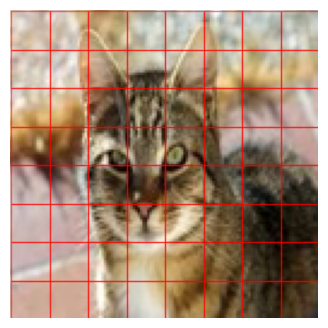

In [2]:
img = load_image(images['cat1'])
draw_pooling_overlay(img, pool_size=16, stride=16)

## Apply convolution, ReLU and pooling
We use Sobel filters for edges, then ReLU and pooling.

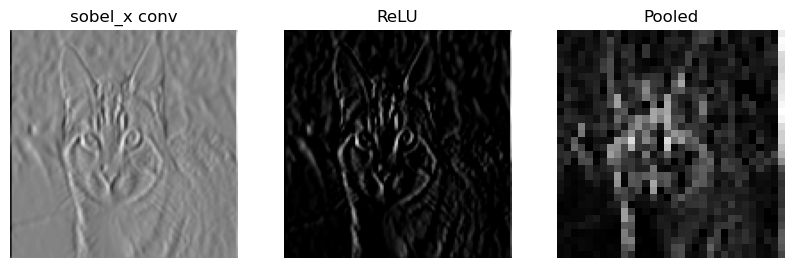

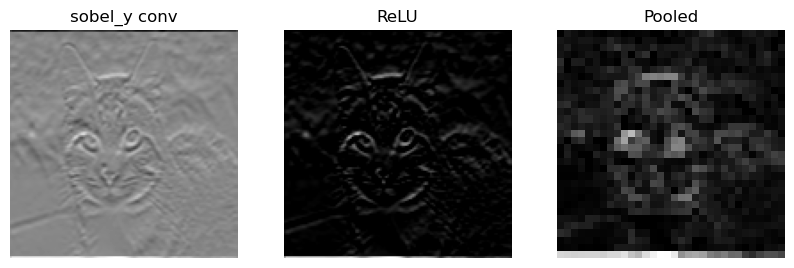

In [3]:
gray = to_grayscale(img)
for name,k in kernels.items():
    conv_map = conv2d(gray,k,padding=1)
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(conv_map,cmap='gray'); plt.title(f"{name} conv"); plt.axis('off')
    relu_map = relu(conv_map)
    plt.subplot(1,3,2); plt.imshow(relu_map,cmap='gray'); plt.title("ReLU"); plt.axis('off')
    pooled = pool2d(relu_map, pool_size=4, stride=4)
    plt.subplot(1,3,3); plt.imshow(pooled,cmap='gray'); plt.title("Pooled"); plt.axis('off')
    plt.show()

## Tiny End-to-End Classifier
We will extract simple convolutional + pooling features from each image, flatten them,
and train a Logistic Regression classifier to separate cats vs dogs.

⚠️ Note: With only 4 images, this is just a **toy demo**, not a real model.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X, y = [], []

for label, name in enumerate(['cat1','cat2','dog1','dog2']):
    img = load_image(images[name])
    gray = to_grayscale(img)
    # Use Sobel_x conv + ReLU + pooling as feature extractor
    conv_map = conv2d(gray, kernels['sobel_x'], padding=1)
    relu_map = relu(conv_map)
    pooled = pool2d(relu_map, pool_size=8, stride=8)
    feat = pooled.flatten()
    X.append(feat)
    # cats = 0, dogs = 1
    y.append(0 if 'cat' in name else 1)

X = np.array(X)
y = np.array(y)

clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(X,y)

print("Training accuracy:", clf.score(X,y))

# Test predictions on the same images (since dataset is tiny)
for name, feat, label in zip(['cat3','dog3','tiger'], X, y):
    pred = clf.predict([feat])[0]
    print(f"Image {name}: true={'cat' if label==0 else 'dog'}, predicted={'cat' if pred==0 else 'dog'}")

Training accuracy: 1.0
Image cat3: true=cat, predicted=cat
Image dog3: true=cat, predicted=cat
Image tiger: true=dog, predicted=dog
